In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

%config InlineBackend.figure_format = "retina"
plt.style.use(["seaborn-colorblind", "seaborn-darkgrid"])

import torch
from torch.autograd import Variable

import pyro
import pyro.distributions as dist
from pyro.util import ng_ones, ng_zeros

from utils import HPDI, Laplace, PI

#### Code 4.1

In [2]:
pos = np.random.uniform(-1, 1, size=(16, 1000)).sum(0)

#### Code 4.2

In [3]:
(1 + np.random.uniform(0, 0.1, size=12)).prod()

1.8827251977056259

#### Code 4.3

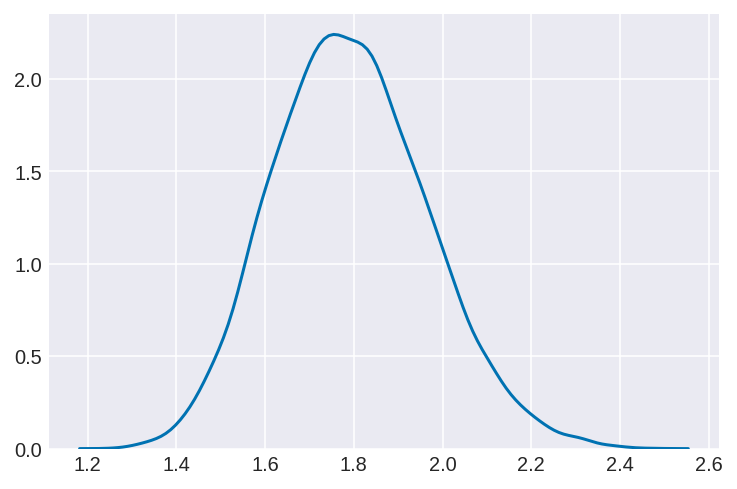

In [4]:
growth = (1 + np.random.uniform(0, 0.1, size=(12, 10000))).prod(0)
sns.kdeplot(growth);

#### Code 4.4

In [5]:
big = (1 + np.random.uniform(0, 0.5, size=(12, 10000))).prod(0)
small = (1 + np.random.uniform(0, 0.01, size=(12, 10000))).prod(0)

#### Code 4.5

In [6]:
log_big = np.log((1 + np.random.uniform(0, 0.5, size=(12, 10000))).prod(0))

#### Code 4.6

In [7]:
w, n = 6, 9
p_grid = np.linspace(0, 1, 100)
posterior = stats.binom.pmf(k=w, n=n, p=p_grid) * stats.uniform.pdf(p_grid, 0, 1)
posterior = posterior / posterior.sum()

#### Code 4.7

In [8]:
d = pd.read_csv("Data/Howell1.csv", sep=";")

#### Code 4.8

In [9]:
print(d.shape)
print(d.dtypes)
d.head()

(544, 4)
height    float64
weight    float64
age       float64
male        int64
dtype: object


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


#### Code 4.9

In [10]:
d.height.head()

0    151.765
1    139.700
2    136.525
3    156.845
4    145.415
Name: height, dtype: float64

#### Code 4.10

In [11]:
d2 = d[d.age >= 18]

#### Code 4.11

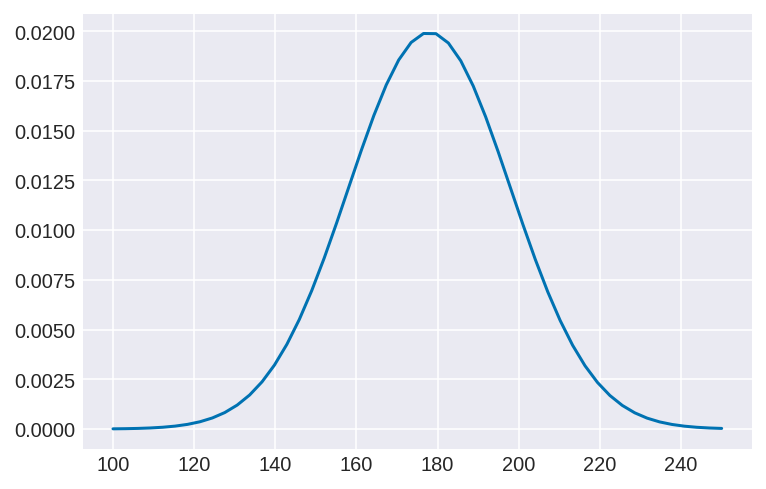

In [12]:
x = np.linspace(100, 250)
plt.plot(x, stats.norm.pdf(x, 178, 20));

#### Code 4.12

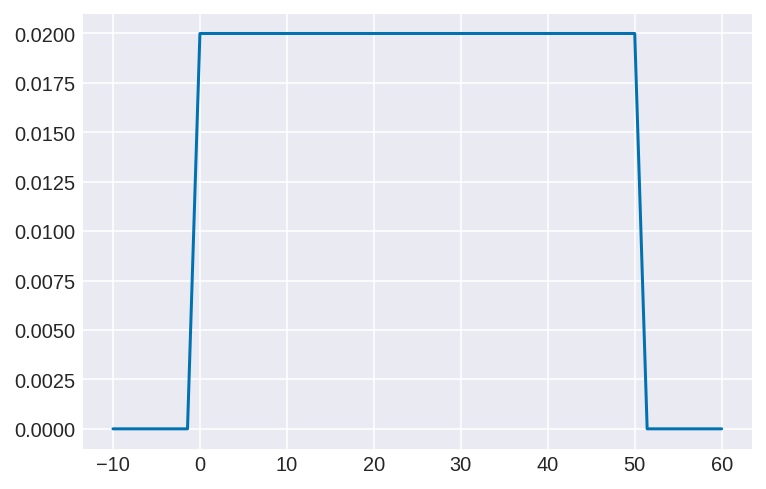

In [13]:
x = np.linspace(-10, 60)
plt.plot(x, stats.uniform.pdf(x, 0, 50));

#### Code 4.13

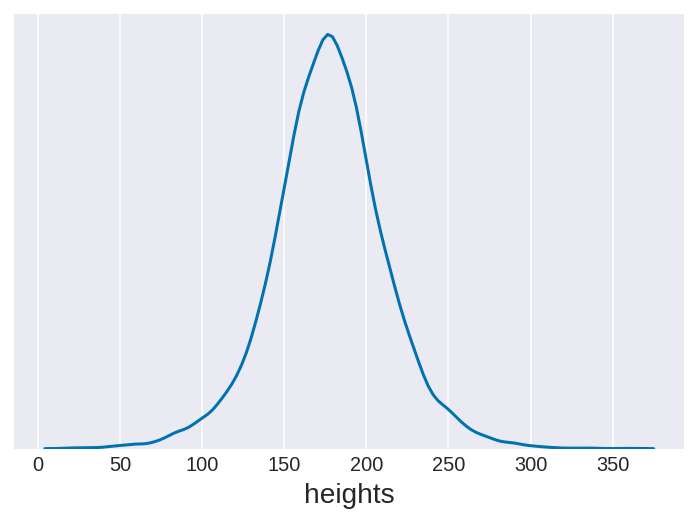

In [14]:
n_samples = int(1e4)
sample_mu = stats.norm.rvs(loc=178, scale=20, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
sns.kdeplot(prior_h)
plt.xlabel("heights", fontsize=14)
plt.yticks([]);

#### Code 4.14

In [15]:
mu_list = np.linspace(140, 160, 200)
sigma_list = np.linspace(4, 9, 200)
post = np.array([(mu, sigma) for mu in mu_list for sigma in sigma_list])
post_LL = np.apply_along_axis(
    lambda post_i: sum(stats.norm.logpdf(d2.height, loc=post_i[0], scale=post_i[1])), 1, post)
post_prod = (post_LL + stats.norm.logpdf(post[:,0], loc=178, scale=20) + 
             stats.uniform.logpdf(post[:,1], loc=0, scale=50))
post_prob = np.exp(post_prod - max(post_prod))

#### Code 4.15

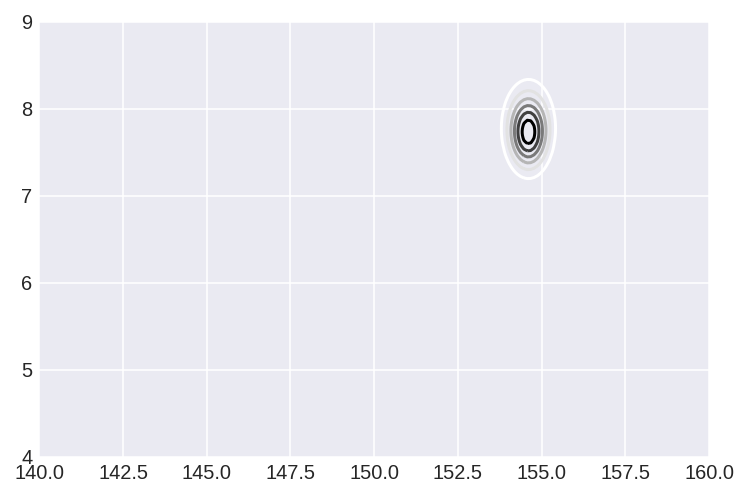

In [16]:
plt.contour(*np.meshgrid(mu_list, sigma_list), post_prob.reshape(200, 200).T);

#### Code 4.16

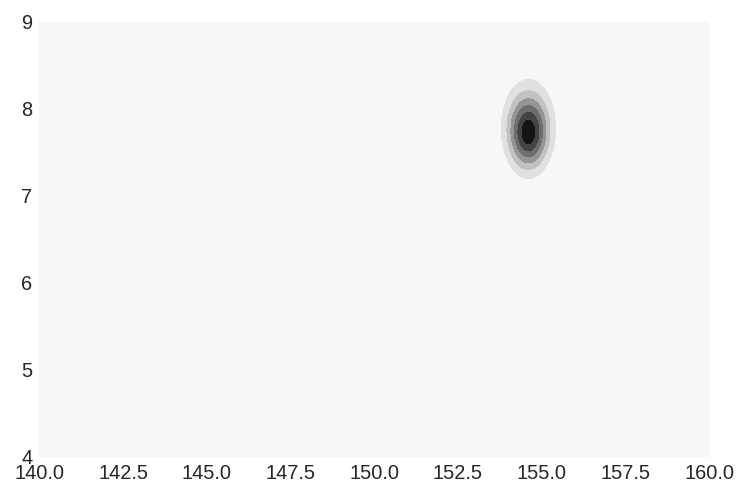

In [17]:
plt.contourf(*np.meshgrid(mu_list, sigma_list), post_prob.reshape(200, 200).T);

#### Code 4.17

In [18]:
sample_rows = np.random.choice(np.arange(len(post)), size=int(1e4), replace=True,
                               p=(post_prob/post_prob.sum()))
sample_mu = post[:,0][sample_rows]
sample_sigma = post[:,1][sample_rows]

#### Code 4.18

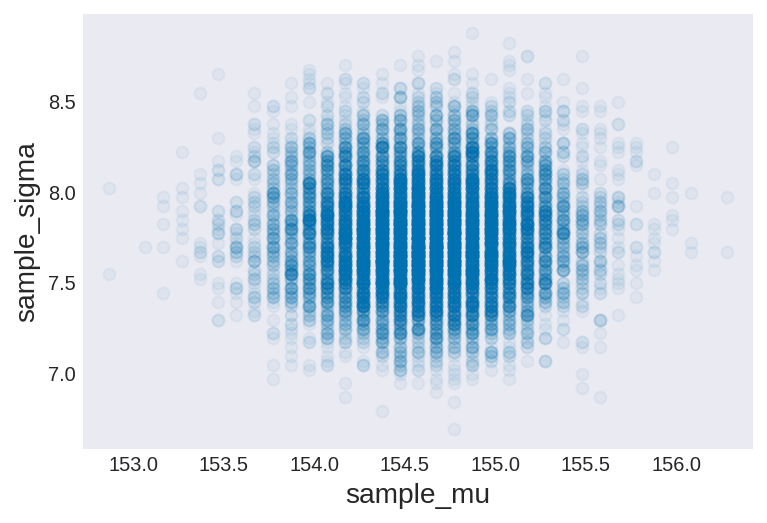

In [19]:
plt.plot(sample_mu, sample_sigma, "o", alpha=0.05)
plt.axis("equal")
plt.grid(False)
plt.xlabel("sample_mu", fontsize=14)
plt.ylabel("sample_sigma", fontsize=14);

#### Code 4.19

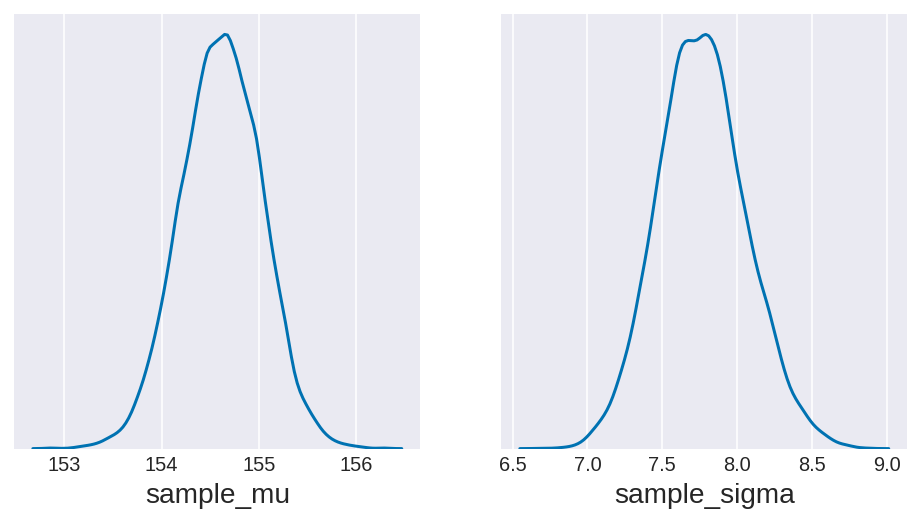

In [20]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(sample_mu, ax=ax[0])
ax[0].set_xlabel("sample_mu", fontsize=14)
ax[0].set_yticks([])
sns.kdeplot(sample_sigma, ax=ax[1])
ax[1].set_xlabel("sample_sigma", fontsize=14)
ax[1].set_yticks([]);

#### Code 4.20

In [21]:
print(HPDI(sample_mu))
HPDI(sample_sigma)

(153.86934673366835, 155.17587939698493)


(7.291457286432161, 8.2211055276381906)

#### Code 4.21

In [22]:
d3 = np.random.choice(d2.height, 20)

#### Code 4.22

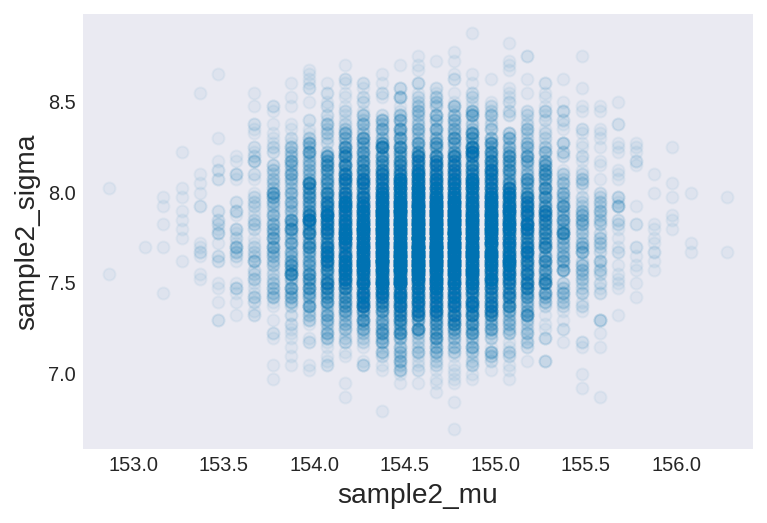

In [23]:
mu_list = np.linspace(140, 160, 200)
sigma_list = np.linspace(4, 9, 200)
post2 = np.array([(mu, sigma) for mu in mu_list for sigma in sigma_list])
post2_LL = np.apply_along_axis(
    lambda post_i: sum(stats.norm.logpdf(d3, loc=post_i[0], scale=post_i[1])), 1, post)
post2_prod = (post_LL + stats.norm.logpdf(post[:,0], loc=178, scale=20) + 
              stats.uniform.logpdf(post[:,1], loc=0, scale=50))
post2_prob = np.exp(post_prod - max(post_prod))
sample2_rows = np.random.choice(np.arange(len(post)), size=int(1e4), replace=True,
                                p=(post_prob/post_prob.sum()))
sample2_mu = post[:,0][sample_rows]
sample2_sigma = post[:,1][sample_rows]
plt.plot(sample2_mu, sample2_sigma, "o", alpha=0.05)
plt.axis("equal")
plt.xlabel("sample2_mu", fontsize=14)
plt.ylabel("sample2_sigma", fontsize=14)
plt.grid(False)

#### Code 4.23

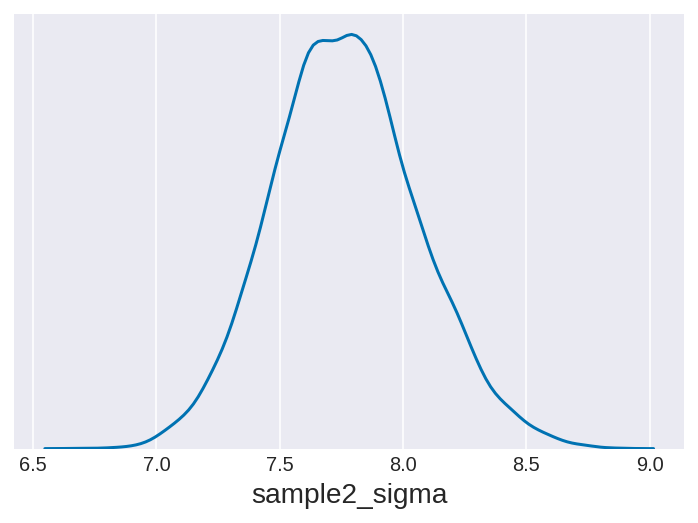

In [24]:
sns.kdeplot(sample2_sigma)
plt.xlabel("sample2_sigma", fontsize=14)
plt.yticks([]);

#### Code 4.24

In [25]:
d = pd.read_csv("Data/Howell1.csv", sep=";")
d2 = d[d.age >= 18]

#### Code 4.25

In [26]:
def m4_1(height):
    mu = pyro.sample("mu", dist.normal, ng_ones(1)*178, ng_ones(1)*20)
    sigma = pyro.sample("sigma", dist.uniform, ng_zeros(1), ng_ones(1)*50)
    pyro.sample("height", dist.normal, mu, sigma, obs=height.view(-1, 1))

#### Code 4.26

In [27]:
height = Variable(torch.Tensor(d2.height.values))
m4_1_qa = Laplace(m4_1, [("mu", 178), ("sigma", 25)]).fit(height, optim_params={"lr": 0.1})

#### Code 4.27

In [28]:
m4_1_qa.precis()

{'mu': {'Mean': 154.6071014404297,
  'StdDev': 0.4119946360588074,
  'pi_0.89': array([ 153.94865444,  155.26554844])},
 'sigma': {'Mean': 7.731332778930664,
  'StdDev': 0.2913860082626343,
  'pi_0.89': array([ 7.26564166,  8.1970239 ])}}

#### Code 4.28

In [29]:
start = [("mu", d2.height.mean()), ("sigma", d2.height.std())]

#### Code 4.29

In [30]:
def m4_2(height):
    mu = pyro.sample("mu", dist.normal, ng_ones(1)*178, ng_ones(1)*0.1)
    sigma = pyro.sample("sigma", dist.uniform, ng_zeros(1), ng_ones(1)*50)
    pyro.sample("height", dist.normal, mu, sigma, obs=height.view(-1, 1))
        
m4_2_qa = Laplace(m4_2, [("mu", 178), ("sigma", 25)]).fit(height, optim_params={"lr": 0.1})
m4_2_qa.precis()

{'mu': {'Mean': 177.86375427246094,
  'StdDev': 0.10023539513349533,
  'pi_0.89': array([ 177.70355875,  178.02394979])},
 'sigma': {'Mean': 24.51756477355957,
  'StdDev': 0.928923487663269,
  'pi_0.89': array([ 23.03296563,  26.00216392])}}

#### Code 4.30

In [31]:
m4_1_qa.fit(height, optim_params={"lr": 0.1})
m4_1_qa.vcov()

Variable containing:
 0.1697  0.0002
 0.0002  0.0849
[torch.FloatTensor of size 2x2]

#### Code 4.31

In [32]:
print(torch.diag(m4_1_qa.vcov()))
m4_1_qa.corr()

Variable containing:
 0.1697
 0.0849
[torch.FloatTensor of size 2]



Variable containing:
 1.0000  0.0018
 0.0018  1.0000
[torch.FloatTensor of size 2x2]

#### Code 4.32

In [33]:
post = m4_1_qa.extract_samples(n=int(1e4))
post[:6]

array([[ 155.48240844,    7.73585696],
       [ 154.45841923,    7.2131694 ],
       [ 155.00727623,    7.71769649],
       [ 154.93237972,    8.68340262],
       [ 154.41618512,    7.6834003 ],
       [ 153.84915496,    7.69939368]])

#### Code 4.33

In [34]:
print(post.mean(axis=0))
print(post.std(axis=0))
HPDI(post[:,0]), HPDI(post[:,1])

[ 154.60808812    7.7301838 ]
[ 0.41170308  0.28995611]


((153.96786681191085, 155.27963421928067),
 (7.2638501847908303, 8.1893142707073032))

#### Code 4.34

In [35]:
post = stats.multivariate_normal.rvs(mean=m4_1_qa.coef().data.numpy(),
                                     cov=m4_1_qa.vcov().data.numpy(), size=int(1e4))

#### Code 4.35

In [36]:
def m4_1_logsigma(height):
    mu = pyro.sample("mu", dist.normal, ng_ones(1)*178, ng_ones(1)*20)
    sigma = pyro.sample("sigma", dist.lognormal, ng_ones(1)*2, ng_ones(1)*10)
    pyro.sample("height", dist.normal, mu, sigma, obs=height.view(-1, 1))
        
m4_1_logsigma_qa = Laplace(m4_1_logsigma, [("mu", 178), ("sigma", np.exp(2))]).fit(
    height, optim_params={"lr": 0.1})

#### Code 4.36

In [37]:
post = m4_1_logsigma_qa.extract_samples()
sigma = post[:, 1]

#### Code 4.37

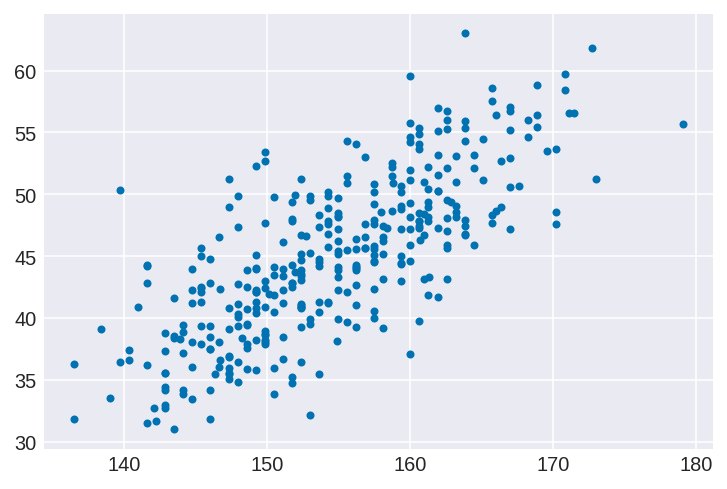

In [38]:
plt.plot(d2.height, d2.weight, ".");

#### Code 4.38

In [39]:
# load data again, since it's a long way back
d = pd.read_csv("Data/Howell1.csv", sep=";")
d2 = d[d.age >= 18]

# fit model
def m4_3(weight, height):
    a = pyro.sample("a", dist.normal, ng_ones(1)*178, ng_ones(1)*100)
    b = pyro.sample("b", dist.normal, ng_zeros(1), ng_ones(1)*10)
    mu = a + b * weight
    sigma = pyro.sample("sigma", dist.uniform, ng_zeros(1), ng_ones(1)*50)
    return pyro.sample("height", dist.normal, mu, sigma.expand_as(mu), obs=height)

weight = Variable(torch.Tensor(d2.weight.values))
height = Variable(torch.Tensor(d2.height.values))
m4_3_qa = Laplace(m4_3, [("a", 178), ("b", 0), ("sigma", 25)]).fit(
    weight, height, optim_params={"lr": 0.1})

#### Code 4.39

In [40]:
#pyro.sample("height", dist.normal, a + b * weight, sigma.expand_as(weight), obs=height)

#### Code 4.40

In [41]:
m4_3_qa.precis()

{'a': {'Mean': 114.21775817871094,
  'StdDev': 1.905385136604309,
  'pi_0.89': array([ 111.17258472,  117.26293163])},
 'b': {'Mean': 0.8978332877159119,
  'StdDev': 0.041922442615032196,
  'pi_0.89': array([ 0.83083313,  0.96483345])},
 'sigma': {'Mean': 5.071739673614502,
  'StdDev': 0.19114559888839722,
  'pi_0.89': array([ 4.76625209,  5.37722726])}}

#### Code 4.41

In [42]:
print(m4_3_qa.corr())
m4_3_qa.precis()

Variable containing:
 1.0000 -0.9899  0.0134
-0.9899  1.0000 -0.0129
 0.0134 -0.0129  1.0000
[torch.FloatTensor of size 3x3]



{'a': {'Mean': 114.21775817871094,
  'StdDev': 1.905385136604309,
  'pi_0.89': array([ 111.17258472,  117.26293163])},
 'b': {'Mean': 0.8978332877159119,
  'StdDev': 0.041922442615032196,
  'pi_0.89': array([ 0.83083313,  0.96483345])},
 'sigma': {'Mean': 5.071739673614502,
  'StdDev': 0.19114559888839722,
  'pi_0.89': array([ 4.76625209,  5.37722726])}}

#### Code 4.42

In [43]:
d2 = d2.assign(weight_c=(d2.weight - d2.weight.mean()))

#### Code 4.43

In [44]:
weight_c = Variable(torch.Tensor(d2.weight_c.values))
m4_4_qa = Laplace(m4_3, [("a", 178), ("b", 0), ("sigma", 25)]).fit(
    weight_c, height, optim_params={'lr': 0.1})

#### Code 4.44

In [45]:
print(m4_4_qa.corr())
m4_4_qa.precis()

Variable containing:
 1.0000e+00 -4.3233e-11  5.0826e-05
 3.1653e-09  1.0000e+00 -2.9617e-05
 5.0830e-05 -2.9609e-05  1.0000e+00
[torch.FloatTensor of size 3x3]



{'a': {'Mean': 154.59727478027344,
  'StdDev': 0.27033039927482605,
  'pi_0.89': array([ 154.16523459,  155.02931497])},
 'b': {'Mean': 0.9050126671791077,
  'StdDev': 0.041927531361579895,
  'pi_0.89': array([ 0.83800437,  0.97202096])},
 'sigma': {'Mean': 5.071866512298584,
  'StdDev': 0.19115318357944489,
  'pi_0.89': array([ 4.76636681,  5.37736622])}}

#### Code 4.45

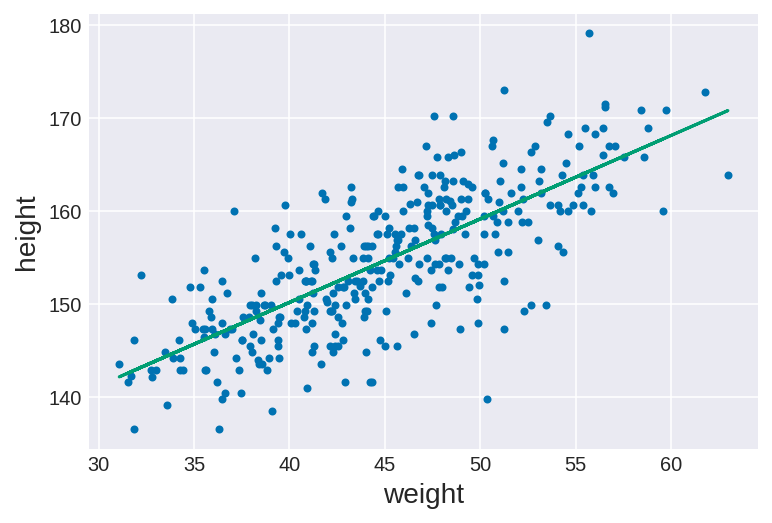

In [46]:
m4_3_qa.fit(weight, height, optim_params={"lr": 0.1})
a, b = m4_3_qa.coef().data[:2]
plt.plot(d2.weight, d2.height, '.')
plt.plot(d2.weight, a + b * d2.weight)
plt.xlabel(d2.columns[1], fontsize=14)
plt.ylabel(d2.columns[0], fontsize=14);

#### Code 4.46

In [47]:
post = m4_3_qa.extract_samples()

#### Code 4.47

In [48]:
post[:5]

array([[ 115.4927601 ,    0.88243674,    5.07843371],
       [ 114.25005199,    0.90457814,    5.16878945],
       [ 114.33415984,    0.89595083,    5.16102644],
       [ 110.88348027,    0.96802045,    5.26647932],
       [ 116.3002626 ,    0.84784887,    5.1891413 ]])

#### Code 4.48

In [49]:
N = [10, 50, 150, 352][0]
dN = d2.iloc[:N]
mN_qa = Laplace(m4_3, [("a", 178), ("b", 0), ("sigma", 25)]).fit(
    weight[:N], height[:N], optim_params={'lr': 0.1})

#### Code 4.49

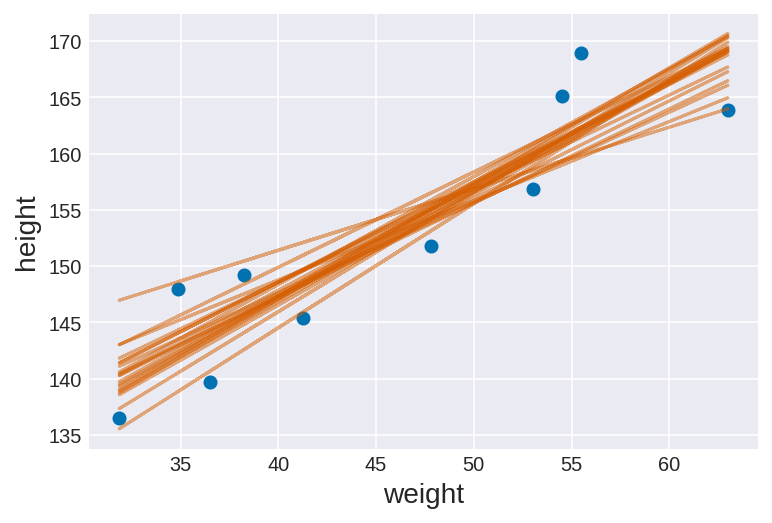

In [50]:
# extract 20 samples from the posterior
post = mN_qa.extract_samples(n=20)

# display raw data and sample size
plt.plot(dN.weight, dN.height, 'C0o')

# plot the lines, with transparency
for i in range(0, 20):
    plt.plot(dN.weight, post[i, 0] + post[i, 1] * dN.weight, 'C2-', alpha=0.5)
plt.xlabel(dN.columns[1], fontsize=14)
plt.ylabel(dN.columns[0], fontsize=14);

#### Code 4.50

In [51]:
m4_3_qa.fit(weight, height, optim_params={"lr": 0.1})
post = m4_3_qa.extract_samples()
mu_at_50 = post[:,0] + post[:,1] * 50

#### Code 4.51

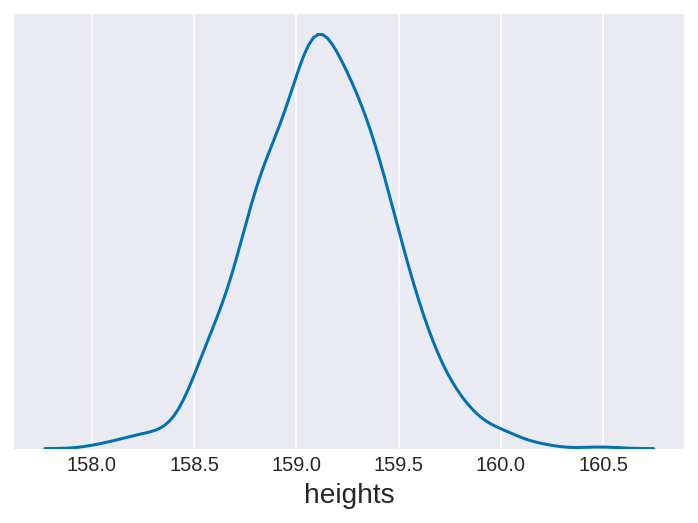

In [52]:
sns.kdeplot(mu_at_50)
plt.xlabel('heights', fontsize=14)
plt.yticks([]);

#### Code 4.52

In [53]:
HPDI(mu_at_50, prob=0.89)

(158.56352714718295, 159.6115623317412)

#### Code 4.53

In [54]:
mu = post[:,0].reshape(-1, 1) + np.outer(post[:,1], d2.weight.values)
print(mu.shape)
mu[0,:5]

(1000, 352)


array([ 156.90045879,  146.80770406,  142.69490651,  161.54312596,
        151.07189293])

#### Code 4.54

In [55]:
# define sequence of weights to compute predictions for
# these values will be on the horizontal axis
weigth_seq = np.arange(25, 71)

# compute mu
# for each sample from posterior
# and for each weight in weight_seq
mu = post[:,0].reshape(-1, 1) + np.outer(post[:,1], weigth_seq)
print(mu.shape)
mu[0,:5]

(1000, 46)


array([ 136.58499927,  137.47502861,  138.36505795,  139.25508729,
        140.14511663])

#### Code 4.55

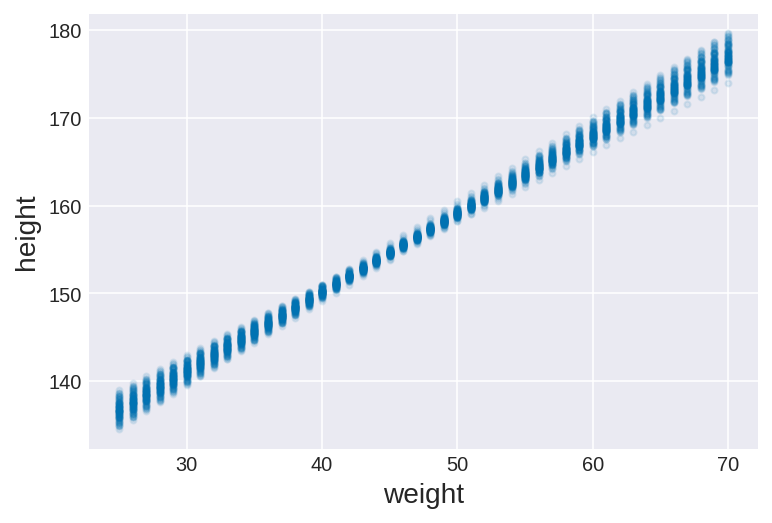

In [56]:
# use visible=False to hide raw data
plt.plot(d2.weight, d2.height, visible=False)

# loop over samples and plot each mu value
plt.plot(weigth_seq, mu[:100,:].T, 'C0.', alpha=0.1)
plt.xlabel('weight', fontsize=14)
plt.ylabel('height', fontsize=14);

#### Code 4.56

In [57]:
# summarize the distribution of mu
mu_mean = mu.mean(0)
mu_HPDI = np.apply_along_axis(HPDI, 0, mu).T

#### Code 4.57

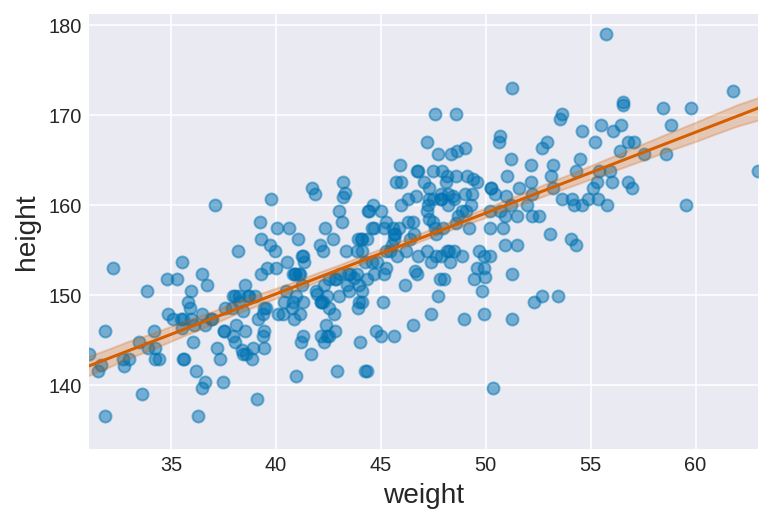

In [58]:
# plot raw data
# fading out points to make line and interval more visible
plt.scatter(d2.weight, d2.height, alpha=0.5)

# plot the MAP line, aka the mean mu for each weight
plt.plot(weigth_seq, mu_mean, "C2")

# plot a shaded region for 89% HPDI
plt.fill_between(weigth_seq, mu_HPDI[:,0], mu_HPDI[:,1], color="C2", alpha=0.25)
plt.xlabel("weight", fontsize=14)
plt.ylabel("height", fontsize=14)
plt.xlim(d2.weight.min(), d2.weight.max());

#### Code 4.58

In [59]:
post = m4_3_qa.extract_samples()
mu_link = lambda weight: post[:,0] + post[:,1] * weight
weight_seq = np.arange(25, 71)
mu = np.apply_along_axis(mu_link, 0, weight_seq.reshape(1, -1))
mu_mean = mu.mean(0)
mu_HPDI = np.apply_along_axis(HPDI, 0, mu).T

#### Code 4.59

In [60]:
sim_height = np.random.normal(loc=mu, scale=np.broadcast_to(post[:,2].reshape(-1, 1), mu.shape))
print(sim_height.shape)
sim_height[0,:5]

(1000, 46)


array([ 144.34472698,  132.97098694,  142.31795571,  141.22160646,
        148.61025436])

#### Code 4.60

In [61]:
height_PI = np.apply_along_axis(PI, 0, sim_height).T

#### Code 4.61

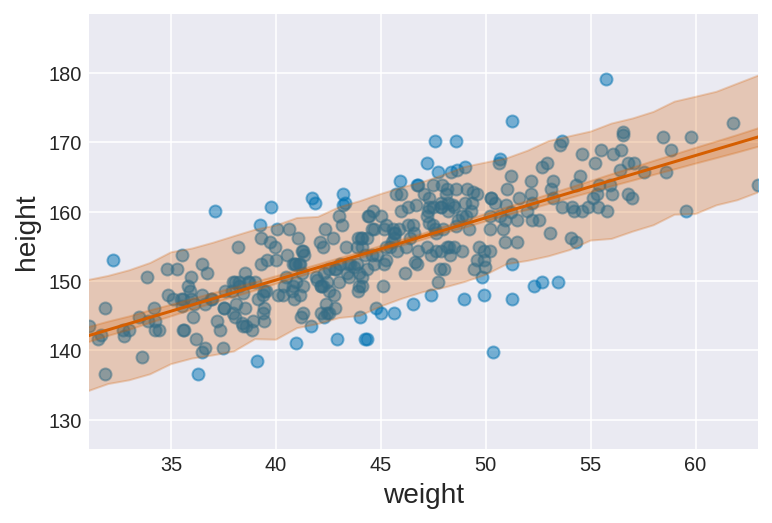

In [62]:
# plot raw data
plt.scatter(d2.weight, d2.height, alpha=0.5)

# draw MAP line
plt.plot(weight_seq, mu_mean, "C2")

# draw HPDI region for line
plt.fill_between(weight_seq, mu_HPDI[:,0], mu_HPDI[:,1], color="C2", alpha=0.25)

# draw PI region for simulated heights
plt.fill_between(weight_seq, height_PI[:,0], height_PI[:,1], color="C2", alpha=0.25)
plt.xlabel("weight", fontsize=14)
plt.ylabel("height", fontsize=14)
plt.xlim(d2.weight.min(), d2.weight.max());

#### Code 4.62

In [63]:
post = m4_3_qa.extract_samples(n=int(1e4))
mu = post[:,0].reshape(-1, 1) + np.outer(post[:,1], weigth_seq)
sim_height = np.random.normal(loc=mu, scale=np.broadcast_to(post[:,2].reshape(-1, 1), mu.shape))
height_PI = np.apply_along_axis(PI, 0, sim_height).T

#### Code 4.63

In [64]:
post = m4_3_qa.extract_samples()
weight_seq = np.arange(25, 71)
sim_height = np.apply_along_axis(
    lambda weight: np.random.normal(loc=post[:,0]+post[:,1]*weight, scale=post[:,2]),
    0, weight_seq.reshape(1, -1))
height_PI = np.apply_along_axis(PI, 0, sim_height).T

#### Code 4.64

In [65]:
print(d.shape)
print(d.dtypes)
d.head()

(544, 4)
height    float64
weight    float64
age       float64
male        int64
dtype: object


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


#### Code 4.65

In [66]:
d["weight_s"] = (d.weight - d.weight.mean()) / d.weight.std()

#### Code 4.66

In [67]:
d["weight_s2"] = d.weight_s ** 2

def m4_5(weight_s, weight_s2, height):
    a = pyro.sample("a", dist.normal, ng_ones(1)*178, ng_ones(1)*100)
    b1 = pyro.sample("b1", dist.normal, ng_zeros(1), ng_ones(1)*10)
    b2 = pyro.sample("b2", dist.normal, ng_zeros(1), ng_ones(1)*10)
    mu = a + b1 * weight_s + b2 * weight_s2
    sigma = pyro.sample("sigma", dist.uniform, ng_zeros(1), ng_ones(1)*50)
    return pyro.sample("height", dist.normal, mu, sigma.expand_as(mu), obs=height)

weight_s = Variable(torch.Tensor(d.weight_s.values))
weight_s2 = Variable(torch.Tensor(d.weight_s2.values))
height = Variable(torch.Tensor(d.height.values))
m4_5_qa = Laplace(m4_5, [("a", 178), ("b1", 0), ("b2", 0), ("sigma", 25)]).fit(
    weight_s, weight_s2, height, optim_params={"lr": 0.1})

#### Code 4.67

In [68]:
m4_5_qa.precis()

{'a': {'Mean': 146.66343688964844,
  'StdDev': 0.3736588656902313,
  'pi_0.89': array([ 146.06625785,  147.26061593])},
 'b1': {'Mean': 21.400341033935547,
  'StdDev': 0.28985124826431274,
  'pi_0.89': array([ 20.93710276,  21.86357931])},
 'b2': {'Mean': -8.415088653564453,
  'StdDev': 0.2813197672367096,
  'pi_0.89': array([-8.86469198, -7.96548533])},
 'sigma': {'Mean': 5.749786376953125,
  'StdDev': 0.17431694269180298,
  'pi_0.89': array([ 5.47119423,  6.02837852])}}

#### Code 4.68

In [69]:
post = m4_5_qa.extract_samples()
weight_seq = np.linspace(-2.2, 2, num=30)
mu = (post[:,0].reshape(-1, 1) + np.outer(post[:,1], weight_seq) +
      np.outer(post[:,2], weight_seq**2))
mu_mean = mu.mean(0)
mu_PI = np.apply_along_axis(PI, 0, mu).T
sim_height = np.random.normal(loc=mu, scale=np.broadcast_to(post[:,3].reshape(-1, 1), mu.shape))
height_PI = np.apply_along_axis(PI, 0, sim_height).T

#### Code 4.69

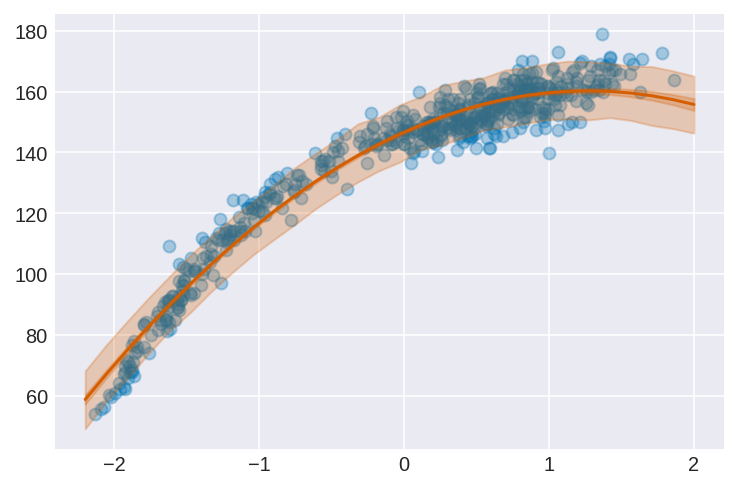

In [70]:
plt.scatter(d.weight_s, d.height, c="C0", alpha=0.3)
plt.plot(weight_seq, mu_mean, "C2")
plt.fill_between(weight_seq, mu_PI[:,0], mu_PI[:,1], color="C2", alpha=0.25)
plt.fill_between(weight_seq, height_PI[:,0], height_PI[:,1], color="C2", alpha=0.25);

#### Code 4.70

In [71]:
d["weight_s3"] = d.weight_s ** 3

def m4_6(weight_s, weight_s2, weight_s3, height):
    a = pyro.sample("a", dist.normal, ng_ones(1)*178, ng_ones(1)*100)
    b1 = pyro.sample("b1", dist.normal, ng_zeros(1), ng_ones(1)*10)
    b2 = pyro.sample("b2", dist.normal, ng_zeros(1), ng_ones(1)*10)
    b3 = pyro.sample("b3", dist.normal, ng_zeros(1), ng_ones(1)*10)
    mu = a + b1 * weight_s + b2 * weight_s2 + b3 * weight_s3
    sigma = pyro.sample("sigma", dist.uniform, ng_zeros(1), ng_ones(1)*50)
    return pyro.sample("height", dist.normal, mu, sigma.expand_as(mu), obs=height)

weight_s3 = Variable(torch.Tensor(d.weight_s3.values))
m4_6_qa = Laplace(m4_6, [("a", 178), ("b1", 0), ("b2", 0), ("b3", 0), ("sigma", 25)]).fit(
    weight_s, weight_s2, weight_s3, height, optim_params={"lr": 0.1})

#### Code 4.71

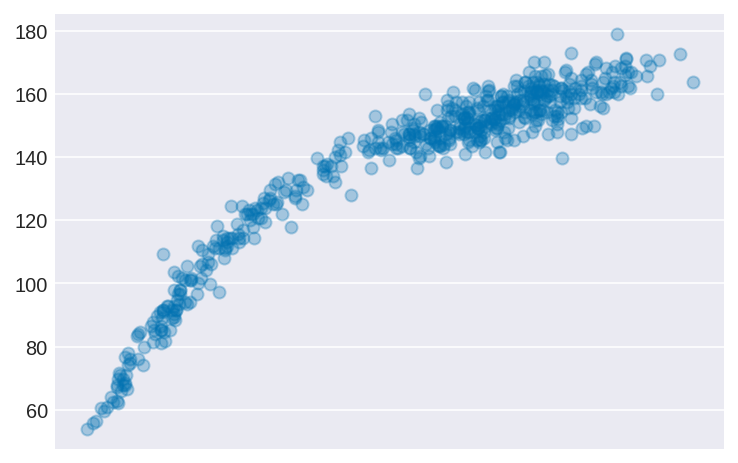

In [72]:
plt.scatter(d.weight_s, d.height, c="C0", alpha=0.3)
plt.xticks([]);

#### Code 4.72

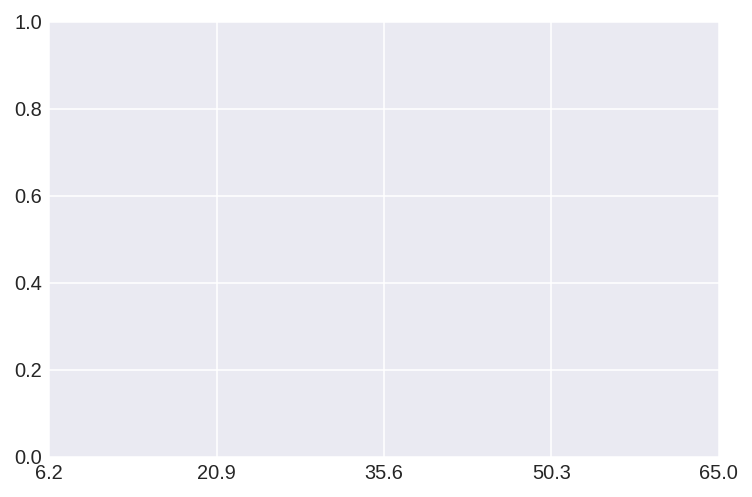

In [73]:
at = np.arange(-2, 3)
labels = at * d.weight.std() + d.weight.mean()
plt.xticks(at, np.round(labels, 1));

#### Code 4.73

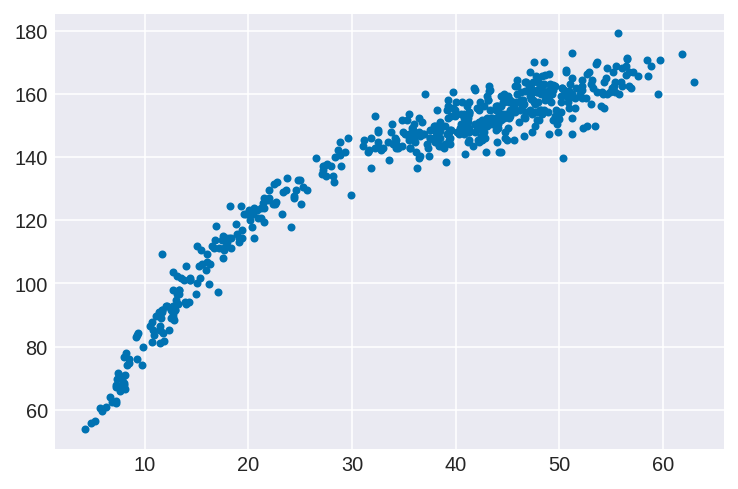

In [76]:
plt.plot(d.weight, d.height, ".");

In [75]:
import platform, sys, IPython, scipy, matplotlib
print("This notebook was createad on a computer {} running {} and using:\n"
      "Python {}\nIPython {}\nPyro {}\nNumPy {}\nSciPy {}\nMatplotlib {}\nSeaborn {}".format(
          platform.machine(), " ".join(platform.linux_distribution()[:2]), sys.version[:5],
          IPython.__version__, pyro.__version__, np.__version__, scipy.__version__,
          matplotlib.__version__, sns.__version__))

This notebook was createad on a computer x86_64 running debian stretch/sid and using:
Python 3.5.4
IPython 6.1.0
Pyro 0.1.2
NumPy 1.13.1
SciPy 0.19.1
Matplotlib 2.0.2
Seaborn 0.8.0
